## Dependencias 

In [37]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from functools import reduce 
pd.set_option('display.max_columns',None)

## Lectura de datos 

In [38]:
data = pd.read_csv('../data/heart_disease.tab',delimiter='\t')
data.shape

(303, 14)

In [39]:
data.sample(5)

diameter narrowing  age  gender    chest pain  rest SBP  cholesterol  \
52                    1   44    male  asymptomatic       112          290   
42                    0   71  female  atypical ang       160          302   
8                     1   63    male  asymptomatic       130          254   
91                    1   62  female  asymptomatic       160          164   
171                   0   53    male  asymptomatic       142          226   

     fasting blood sugar > 120               rest ECG  max HR  exerc ind ang  \
52                           0  left vent hypertrophy     153              0   
42                           0                 normal     162              0   
8                            0  left vent hypertrophy     147              0   
91                           0  left vent hypertrophy     145              0   
171                          0  left vent hypertrophy     111              1   

     ST by exercise slope peak exc ST  major vessels colored  \
52              0.0         upsloping                    1.0   
42              0.4         upsloping                    2.0   
8               1.4              flat                    1.0   
91              6.2       downsloping                    3.0   
171             0.0         upsloping                    0.0   

                  thal  
52              normal  
42              normal  
8    reversable defect  
91   reversable defect  
171  reversable defect

## Clasificación de variables 

In [40]:
varc = ['age','rest SBP','cholesterol','max HR','ST by exercise','major vessels colored']
vard = [ 'gender', 'chest pain',  'fasting blood sugar > 120', 'rest ECG', 'exerc ind ang',  'slope peak exc ST','thal']
vart = ['diameter narrowing']

In [43]:
for v in varc:
    data[v] = pd.to_numeric(data[v],errors='coerce')
for v in vard:
    data[v] =data[v].fillna('MISSING')

## Partición 

In [44]:
train,valid = train_test_split(data,test_size=0.2)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((242, 14), (61, 14))

### Matriz de predictoras $\mathcal{X}$

In [45]:
oh = OneHotEncoder(drop='if_binary',sparse_output=False)
oh.fit(train[vard])
varoh = list(oh.get_feature_names_out())
varoh

['gender_male',
 'chest pain_asymptomatic',
 'chest pain_atypical ang',
 'chest pain_non-anginal',
 'chest pain_typical ang',
 'fasting blood sugar > 120_1',
 'rest ECG_ST-T abnormal',
 'rest ECG_left vent hypertrophy',
 'rest ECG_normal',
 'exerc ind ang_1',
 'slope peak exc ST_downsloping',
 'slope peak exc ST_flat',
 'slope peak exc ST_upsloping',
 'thal_MISSING',
 'thal_fixed defect',
 'thal_normal',
 'thal_reversable defect']

In [46]:
X = train[varc].copy()
X[varoh] = oh.transform(train[vard])
X.head()
im = SimpleImputer(strategy='median')
im.fit(X)
X = pd.DataFrame(im.transform(X),columns=X.columns)

### Vector respuesta $\vec{y}$

In [47]:
y = train[vart[0]]
y.head()

0    0
1    1
2    1
3    0
4    1
Name: diameter narrowing, dtype: int64

## Aprendizaje 

In [48]:
var = varc+varoh

### Predictoras más fuertes 

In [49]:
sk = SelectKBest(k=len(var))
sk.fit(X,y)

SelectKBest(k=23)

<Axes: >

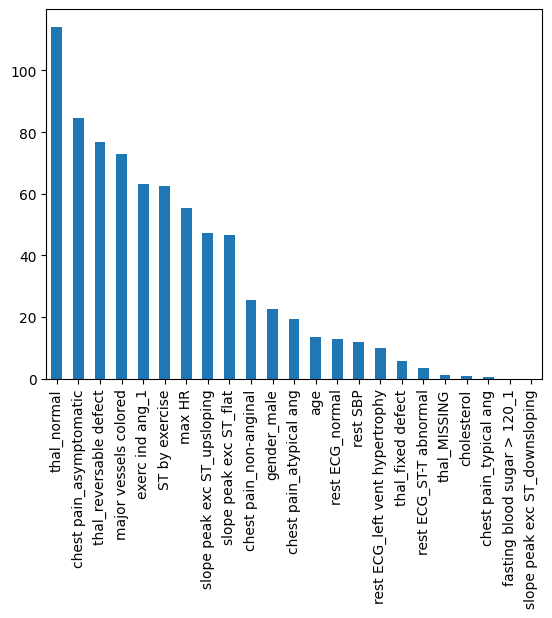

In [50]:
pd.Series(dict(zip(var,sk.scores_))).sort_values(ascending=False).plot(kind='bar')

In [51]:
k = 5 
sk = SelectKBest(k=k)
sk.fit(X,y)

SelectKBest(k=5)

In [52]:
best = [v for v,s in zip(var,sk.get_support()) if s]
best

['major vessels colored',
 'chest pain_asymptomatic',
 'exerc ind ang_1',
 'thal_normal',
 'thal_reversable defect']

In [53]:
X = train[varc].copy()
X[varoh] = oh.transform(train[vard])
X.head()
im = SimpleImputer(strategy='median')
im.fit(X[best])
X = pd.DataFrame(im.transform(X[best]),columns=best)

### Híper-parametrización

In [54]:
hparam_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': np.logspace(-4, 4, 10),
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
    'max_iter': [100, 200, 500, 1000],
    'fit_intercept': [True, False],
    'l1_ratio': np.linspace(0, 1, 5)  # l1_ratio is used only if penalty='elasticnet'
}


In [55]:
reduce(lambda x,y: x*y, map(len,hparam_grid.values()))

6400

In [56]:
lr = LogisticRegression()

In [57]:
grid = GridSearchCV(
    estimator=lr,
    param_grid=hparam_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=True,
    cv=5
)

In [58]:
grid.fit(X,y)

Fitting 5 folds for each of 6400 candidates, totalling 32000 fits


/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/sklearn/linear_mo

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'fit_intercept': [True, False],
                         'l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                         'max_iter': [100, 200, 500, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg']},
             scoring='roc_auc', verbose=True)

In [59]:
grid.best_score_

np.float64(0.9245363332319855)

In [60]:
lr = grid.best_estimator_

### Aprendizaje final $\vec{y} = f (\mathcal{X};\theta)$  (Ahora si vamos a aprender el modelo)

In [61]:
lr.fit(X,y)

LogisticRegression(C=np.float64(0.046415888336127774),
                   l1_ratio=np.float64(0.25), penalty='elasticnet',
                   solver='saga')

#### $\vec{\theta},\theta_0$

In [62]:
lr.intercept_,lr.coef_

(array([-0.81990767]),
 array([[ 0.6222915 ,  0.5159133 ,  0.42702475, -0.54478173,  0.36644861]]))

In [63]:
lr.feature_names_in_

array(['major vessels colored', 'chest pain_asymptomatic',
       'exerc ind ang_1', 'thal_normal', 'thal_reversable defect'],
      dtype=object)

## Generalización del modelo (qué tan bien se comporta en datos que nunca vió, es importante aplicar TODAS las transfromaciones previas)

In [64]:
Xv = valid[varc].copy()
Xv[varoh] = oh.transform(valid[vard])
Xv = pd.DataFrame(im.transform(Xv[best]),columns=best)

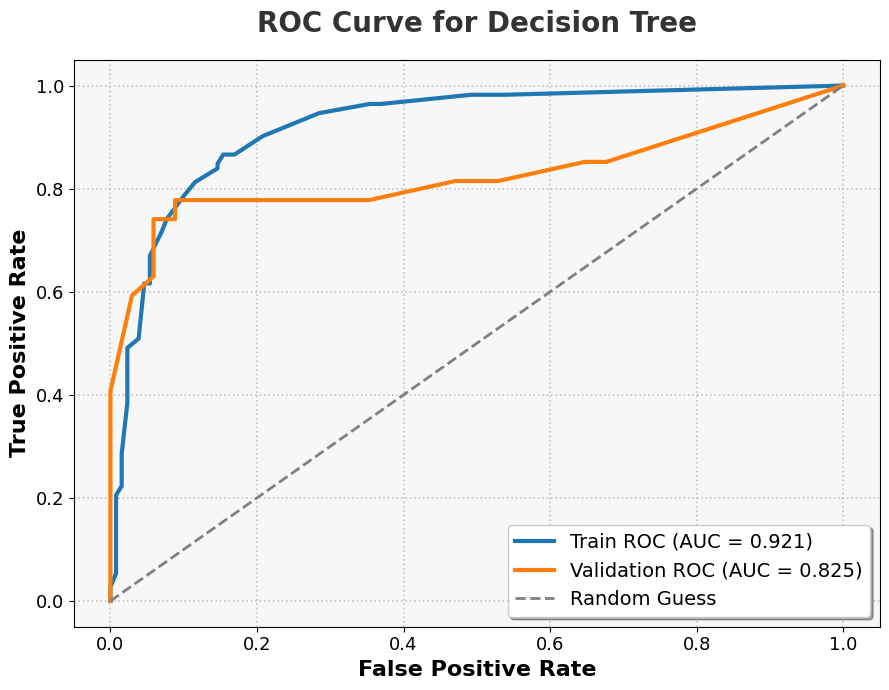

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Training ROC and AUC
y_train_proba = lr.predict_proba(X)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y, y_train_proba)
auc_train = auc(fpr_train, tpr_train)

# Validation ROC and AUC
y_valid = valid['diameter narrowing']
y_valid_proba = lr.predict_proba(Xv)[:, 1]
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
auc_valid = auc(fpr_valid, tpr_valid)

plt.figure(figsize=(9, 7))
plt.plot(fpr_train, tpr_train, color='#1f77b4', lw=3, label=f'Train ROC (AUC = {auc_train:.3f})')
plt.plot(fpr_valid, tpr_valid, color='#ff7f0e', lw=3, label=f'Validation ROC (AUC = {auc_valid:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')

plt.title('ROC Curve for Decision Tree', fontsize=20, fontweight='bold', color='#333333', pad=20)
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.legend(fontsize=14, loc='lower right', frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle=':', linewidth=1.2, alpha=0.7)
plt.gca().set_facecolor('#f7f7f7')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.tight_layout()
plt.show()

## Uso del modelo 

In [67]:

# Generate predicted probabilities for both training and validation sets using the logistic regression model
y_train_proba = lr.predict_proba(X)[:, 1]
y_valid_proba = lr.predict_proba(Xv)[:, 1]

# Define probability bins from 0 to 1 in steps of 0.2
prob_bins = np.arange(0, 1.1, 0.2)  # [0. , 0.2, 0.4, ..., 1.0]
prob_labels = [f"{prob_bins[i]:.1f}-{prob_bins[i+1]:.1f}" for i in range(len(prob_bins)-1)]

# Bin the probabilities
train_prob_range = pd.cut(y_train_proba, bins=prob_bins, labels=prob_labels, include_lowest=True)
valid_prob_range = pd.cut(y_valid_proba, bins=prob_bins, labels=prob_labels, include_lowest=True)

# Build DataFrames for train and valid
df_train_probs = pd.DataFrame({
    'target': y.values,
    'probability': y_train_proba,
    'prob_range': train_prob_range,
    'sample': 'train'
})

df_valid_probs = pd.DataFrame({
    'target': y_valid.values,
    'probability': y_valid_proba,
    'prob_range': valid_prob_range,
    'sample': 'valid'
})

# Concatenate into a single DataFrame
df_probs = pd.concat([df_train_probs, df_valid_probs], ignore_index=True)

# Show the first few rows
df_probs.head()



target  probability prob_range sample
0       0     0.388539    0.2-0.4  train
1       1     0.796994    0.6-0.8  train
2       1     0.388539    0.2-0.4  train
3       0     0.203479    0.2-0.4  train
4       1     0.542108    0.4-0.6  train

In [71]:
df_probs['prob_range'].value_counts()

prob_range
0.2-0.4    157
0.6-0.8     63
0.4-0.6     54
0.8-1.0     29
0.0-0.2      0
Name: count, dtype: int64

In [69]:
df_probs.drop('probability',axis=1).assign(n=1).groupby(['target','prob_range','sample']).count().to_clipboard()

/var/folders/b2/142kycp96wdg69k6pkw9_vf00000gp/T/ipykernel_36194/2932223669.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_probs.drop('probability',axis=1).assign(n=1).groupby(['target','prob_range','sample']).count().to_clipboard()


In [72]:
!python -V

Python 3.13.7
